<a href="https://colab.research.google.com/github/Hong-Hyun-Seung/upstage-basic-deeplearning/blob/main/MRC_Practice_5_Dense_Passage_Retrieval_(In_batch)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5강) BERT를 활용한 Dense Passage Retrieval 실습

### Requirements

In [1]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 298 kB 12.6 MB/s 
     |████████████████████████████████| 243 kB 50.5 MB/s 
     |████████████████████████████████| 132 kB 43.6 MB/s 
     |████████████████████████████████| 61 kB 491 kB/s 
     |████████████████████████████████| 1.1 MB 53.1 MB/s 
     |████████████████████████████████| 271 kB 51.4 MB/s 
     |████████████████████████████████| 160 kB 48.9 MB/s 
     |████████████████████████████████| 192 kB 41.1 MB/s 
     |████████████████████████████████| 3.4 MB 10.8 MB/s 
     |████████████████████████████████| 895 kB 39.0 MB/s 
     |████████████████████████████████| 596 kB 45.5 MB/s 
     |████████████████████████████████| 3.3 MB 39.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 데이터셋 로딩


KorQuAD(MRC용 한국어 데이터셋) train 데이터셋을 학습 데이터로 활용

In [2]:
from datasets import load_dataset

dataset = load_dataset("squad_kor_v1")

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/7.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/770k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad_kor_v1 downloaded and prepared to /root/.cache/huggingface/datasets/squad_kor_v1/squad_kor_v1/1.0.0/18d4f44736b8ee85671f63cb84965bfb583fa0a4ff2df3c2e10eee9693796725. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## 토크나이저 준비 - Huggingface 제공 tokenizer 이용

BERT를 encoder로 사용하므로, hugginface에서 제공하는 "bert-base-multilingual-cased" tokenizer를 활용

In [3]:
from transformers import AutoTokenizer
import numpy as np

model_checkpoint = "bert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [5]:
dataset['train'][0]

{'answers': {'answer_start': [54], 'text': ['교향곡']},
 'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 'id': '6566495-0-0',
 'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 'title': '파우스트_서곡'}

In [6]:
tokenized_input = tokenizer(dataset['train'][0]['context'], padding="max_length", truncation=True)
tokenizer.decode(tokenized_input['input_ids'])

'[CLS] 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 [UNK] 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡 ( 1악장 ) 을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## Dense encoder (BERT) 학습 시키기

HuggingFace BERT를 활용하여 question encoder, passage encoder 학습

In [7]:
from tqdm import tqdm, trange
import argparse
import random
import torch
import torch.nn.functional as F
from transformers import BertModel, BertPreTrainedModel, AdamW, TrainingArguments, get_linear_schedule_with_warmup

torch.manual_seed(2021)
torch.cuda.manual_seed(2021)
np.random.seed(2021)
random.seed(2021)

1) Training Dataset 준비하기 (question, passage pairs)

---



In [8]:
# Use subset (128 example) of original training dataset 
sample_idx = np.random.choice(range(len(dataset['train'])), 128)
training_dataset = dataset['train'][sample_idx]

In [9]:
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)

q_seqs = tokenizer(training_dataset['question'], padding="max_length", truncation=True, return_tensors='pt')
p_seqs = tokenizer(training_dataset['context'], padding="max_length", truncation=True, return_tensors='pt')


In [10]:
print(len(q_seqs))

3


In [11]:
q_seqs

{'input_ids': tensor([[  101, 20656, 10530,  ...,     0,     0,     0],
        [  101, 10295, 10530,  ...,     0,     0,     0],
        [  101, 84097,  9258,  ...,     0,     0,     0],
        ...,
        [  101,  9730, 43739,  ...,     0,     0,     0],
        [  101, 37207, 60886,  ...,     0,     0,     0],
        [  101, 10270, 47955,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [12]:
train_dataset = TensorDataset(p_seqs['input_ids'], p_seqs['attention_mask'], p_seqs['token_type_ids'], 
                        q_seqs['input_ids'], q_seqs['attention_mask'], q_seqs['token_type_ids'])

Dataset을 학습하기 위해서 tensordataset 으로 변경 해준다 + question 데이터와 context 데이터를 합쳐준다(학습할때 용이하기 위해서) 
=> input_ids, attention_mask, token_type_ids를 가져온다  -> Bert에는 input으로 1.input_id, 2.attention_mask, 3.token_type_id 를 집어넣는다(밑에 그림 참고)

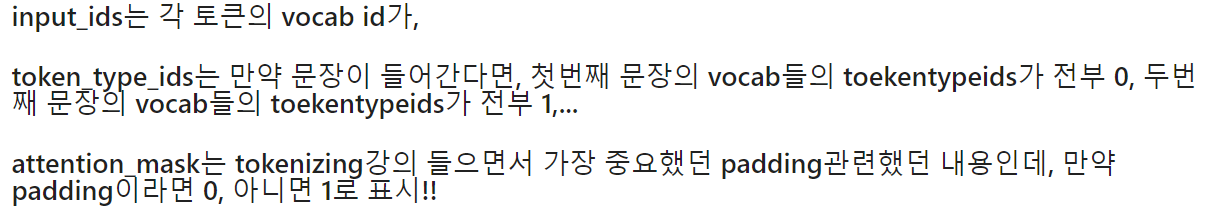

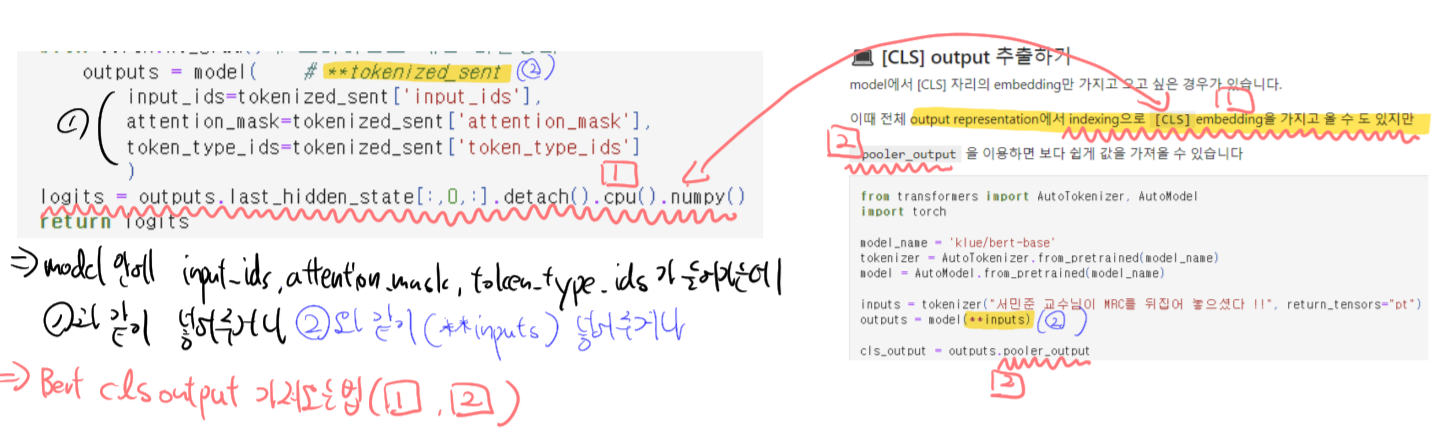

2) BERT encoder 학습시키기

BertEncoder 모델 정의 후, question encoder, passage encoder에 pre-trained weight 불러오기

In [13]:
class BertEncoder(BertPreTrainedModel):
  def __init__(self, config):
    super(BertEncoder, self).__init__(config)

    self.bert = BertModel(config)
    self.init_weights()
      
  def forward(self, input_ids, 
              attention_mask=None, token_type_ids=None): 
  
      outputs = self.bert(input_ids,
                          attention_mask=attention_mask,
                          token_type_ids=token_type_ids)
      
      pooled_output = outputs[1] #output은 cls 토큰에만 해당되는 임배딩이다

      return pooled_output


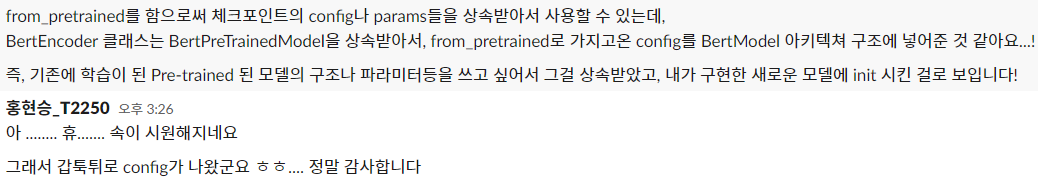

In [14]:
# load pre-trained model on cuda (if available)
p_encoder = BertEncoder.from_pretrained(model_checkpoint)
q_encoder = BertEncoder.from_pretrained(model_checkpoint)

if torch.cuda.is_available():
  p_encoder.cuda()
  q_encoder.cuda()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertEncoder: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertEncoder: ['cls.predictions.decode

#### RandomSampler 설명
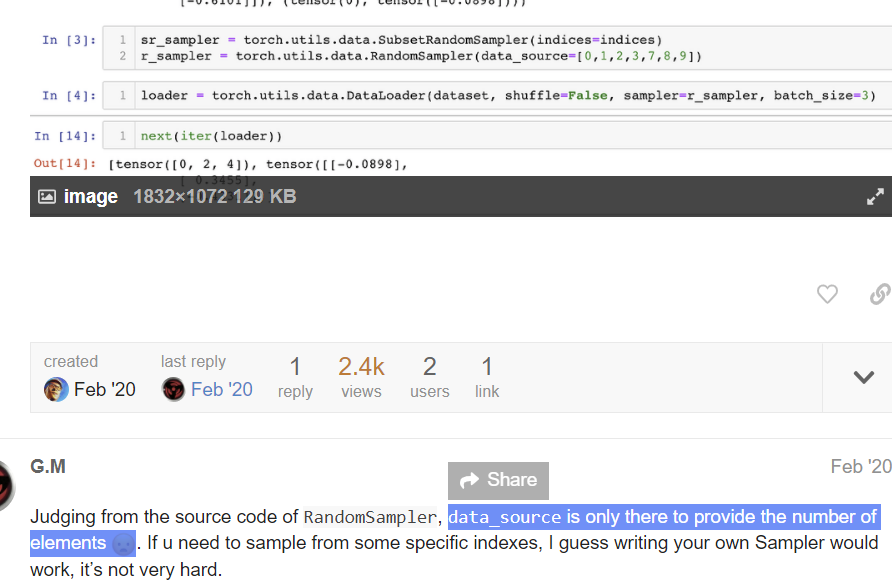

Train function 정의 후, 두개의 encoder fine-tuning 하기 (In-batch negative 활용) 


In [15]:
def train(args,  dataset, p_model, q_model):
  
  # Dataloader
  train_sampler = RandomSampler(dataset)
  train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=args.per_device_train_batch_size)

  # Optimizer
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
        {'params': [p for n, p in p_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in p_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        {'params': [p for n, p in q_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in q_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
  optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
  t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total)

  # Start training!
  global_step = 0
  
  p_model.zero_grad()
  q_model.zero_grad()
  torch.cuda.empty_cache()
  
  train_iterator = trange(int(args.num_train_epochs), desc="Epoch")

  for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")

    for step, batch in enumerate(epoch_iterator):
      q_encoder.train()
      p_encoder.train()
      
      targets = torch.zeros(args.per_device_train_batch_size).long()
      if torch.cuda.is_available():
        batch = tuple(t.cuda() for t in batch)
        print(f"batch is {batch}")
        targets = targets.cuda()

      p_inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2]
                  }
      print(f"p_input inpud_ids is {p_inputs['input_ids']}")
      print(f"p_input attention mask  is {p_inputs['attention_mask']}")
      q_inputs = {'input_ids': batch[3],
                  'attention_mask': batch[4],
                  'token_type_ids': batch[5]}
      
      p_outputs = p_model(**p_inputs)  #(batch_size, emb_dim) #"**" 땜시 알아서 나눠서 들어간다 bert내로
      q_outputs = q_model(**q_inputs)  #(batch_size, emb_dim)
      print(f"p_outputs is {p_outputs}")
      print(f"q_outputs is {q_outputs}")
       # Calculate similarity score & loss
      sim_scores = torch.matmul(q_outputs, torch.transpose(p_outputs, 0, 1))  # (batch_size, emb_dim) x (emb_dim, batch_size) = (batch_size, batch_size)

      # target: position of positive samples = diagonal element 
      targets = torch.arange(0, args.per_device_train_batch_size).long()
      if torch.cuda.is_available():
        targets = targets.to('cuda')

      sim_scores = F.log_softmax(sim_scores, dim=1)
      print(f"sim_scoresis {sim_scores}")
      print(f"target is {targets}")
      loss = F.nll_loss(sim_scores, targets)
      print(f"loss is {loss}")

      loss.backward()
      optimizer.step()
      scheduler.step()
      q_model.zero_grad()
      p_model.zero_grad()
      global_step += 1
      
      torch.cuda.empty_cache()


    
  return p_model, q_model


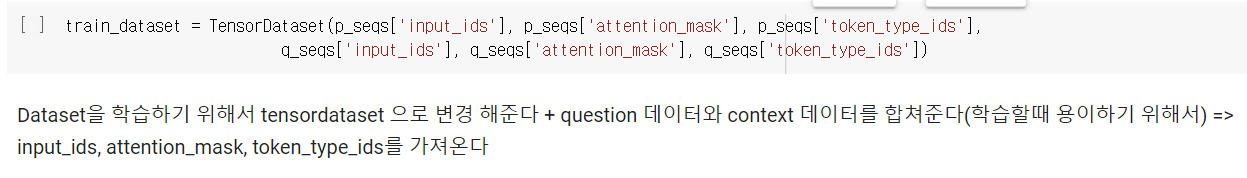

In [16]:
args = TrainingArguments(
    output_dir="dense_retireval",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01
)


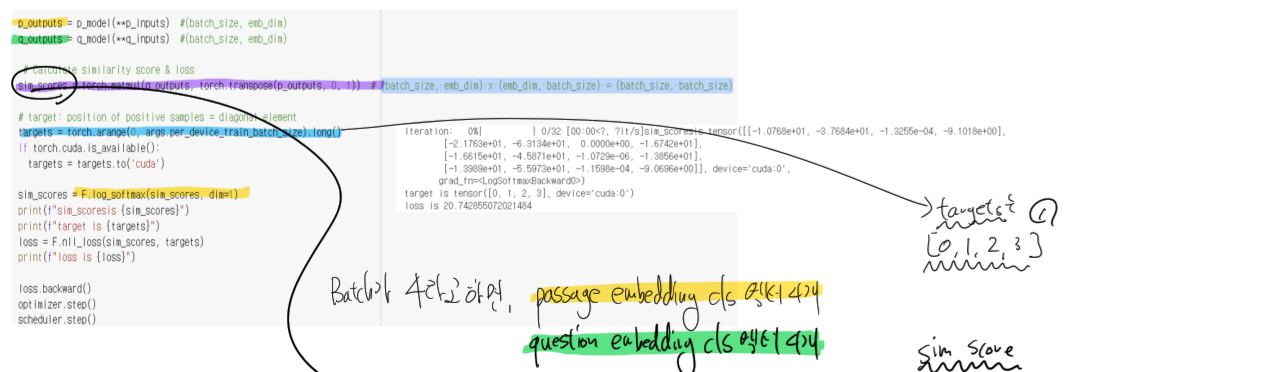

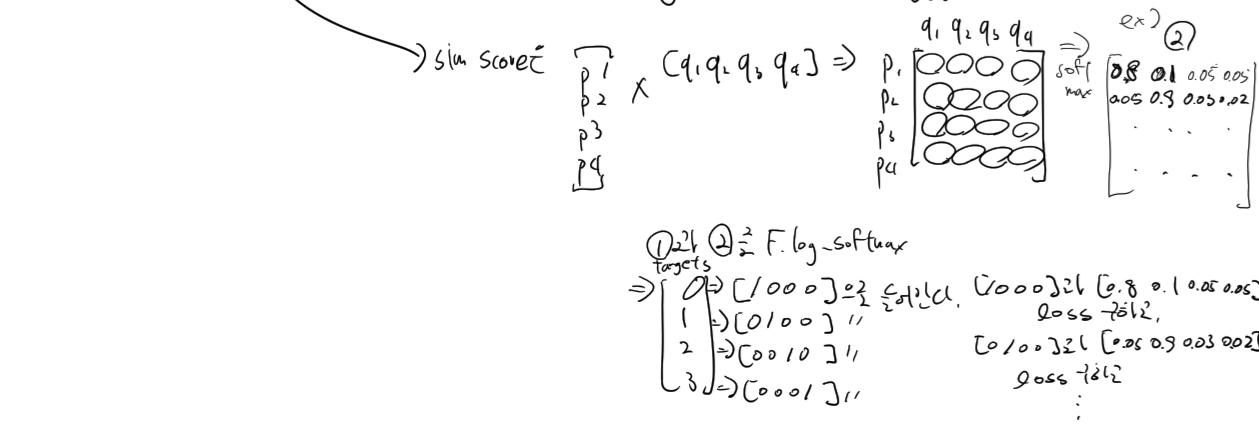

In [17]:
p_encoder, q_encoder = train(args, train_dataset, p_encoder, q_encoder)

Iteration:   0%|          | 0/32 [00:00<?, ?it/s]

batch is (tensor([[  101,  8888, 20626,  ...,     0,     0,     0],
        [  101,  9472, 51431,  ...,     0,     0,     0],
        [  101, 51438, 10954,  ...,     0,     0,     0],
        [  101,  9095, 29364,  ...,     0,     0,     0]], device='cuda:0'), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), tensor([[  101,  9627, 31605,  ...,     0,     0,     0],
        [  101,  9665, 22458,  ...,     0,     0,     0],
        [  101,  9428, 20626,  ...,     0,     0,     0],
        [  101,   124, 69023,  ...,     0,     0,     0]], device='cuda:0'), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), tensor([[0, 0, 0,  ...,


Epoch:   0%|          | 0/2 [00:02<?, ?it/s]


batch is (tensor([[  101, 19456, 16464,  ...,     0,     0,     0],
        [  101, 26352, 16650,  ...,     0,     0,     0],
        [  101, 59906, 12030,  ...,     0,     0,     0],
        [  101, 17289, 45424,  ...,     0,     0,     0]], device='cuda:0'), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'), tensor([[  101, 18950, 17206,  ...,     0,     0,     0],
        [  101,  9901, 86732,  ...,     0,     0,     0],
        [  101,  9903, 25934,  ...,     0,     0,     0],
        [  101,  9538, 12605,  ...,     0,     0,     0]], device='cuda:0'), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), tensor([[0, 0, 0,  ...,

RuntimeError: ignored

## Dense Embedding을 활용하여 passage retrieval 실습해보기

In [ ]:

valid_corpus = list(set([example['context'] for example in dataset['validation']]))[:10]
sample_idx = random.choice(range(len(dataset['validation'])))
query = dataset['validation'][sample_idx]['question']
ground_truth = dataset['validation'][sample_idx]['context']

if not ground_truth in valid_corpus:
  valid_corpus.append(ground_truth)

print(query)
print(ground_truth, '\n\n')

# valid_corpus

앞서 학습한 passage encoder, question encoder을 이용해 dense embedding 생성

In [ ]:
def to_cuda(batch):
  return tuple(t.cuda() for t in batch)

In [ ]:
with torch.no_grad():
  p_encoder.eval()
  q_encoder.eval()

  q_seqs_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt').to('cuda')
  q_emb = q_encoder(**q_seqs_val).to('cpu')  #(num_query, emb_dim)

  p_embs = []
  for p in valid_corpus:
    p = tokenizer(p, padding="max_length", truncation=True, return_tensors='pt').to('cuda')
    p_emb = p_encoder(**p).to('cpu').numpy()
    p_embs.append(p_emb)

p_embs = torch.Tensor(p_embs).squeeze()  # (num_passage, emb_dim)

print(p_embs.size(), q_emb.size())

생성된 embedding에 dot product를 수행 => Document들의 similarity ranking을 구함

In [ ]:
dot_prod_scores = torch.matmul(q_emb, torch.transpose(p_embs, 0, 1))
print(dot_prod_scores.size())

rank = torch.argsort(dot_prod_scores, dim=1, descending=True).squeeze()
print(dot_prod_scores)
print(rank)

Top-5개의 passage를 retrieve 하고 ground truth와 비교하기

In [ ]:
k = 5
print("[Search query]\n", query, "\n")
print("[Ground truth passage]")
print(ground_truth, "\n")

for i in range(k):
  print("Top-%d passage with score %.4f" % (i+1, dot_prod_scores.squeeze()[rank[i]]))
  print(valid_corpus[rank[i]])